In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [140]:
import networkx as nx
import os
import matplotlib.pyplot as plt
from IPython.core.display import SVG, display
from sysgym.envs.rocksdb import schema as rocksdb_schema
import pandas as pd

import seaborn as sns

def draw(graph, path = None, better_label: bool = True):

    if better_label:
        for node in graph.nodes():
            graph.nodes[node]['label'] = str(node).replace("_", " ").title().replace(" ", "").replace("Macros",
                                                                                                      "").replace(
                "Micros", "").replace("Iops", "IOPS").replace(".", "").replace("Size", "Sz").replace("Number",
                                                                                                     "Num").replace(
                "Level0", "L0")

    fmt = "svg"
    if path is not None:
        if path.endswith(".svg"):
            fmt = "svg"
        elif path.endswith(".pdf"):
            fmt = "pdf"
        else:
            print("Unrecognized file extension", path.split(".")[-1])
    svg = nx.nx_agraph.to_agraph(graph).draw(path = path, prog = "dot", format = fmt, args = "-Gsize=10")
    if path is None:
        display(SVG(svg))


def rocksdb_10param_strctv2() -> nx.DiGraph:
    expert = nx.DiGraph()

    expert.add_edges_from(
        [
            ("write_buffer_size", "db_write_micros.p95"),
            ("max_write_buffer_number", "db_write_micros.p95"),
            ("min_write_buffer_number_to_merge", "db_write_micros.p95"),
            ("block_size", "db_write_micros.p95"),
            ("db_write_micros.p95", "iops"),
            ("level0_file_num_compaction_trigger", "compaction_times_micros.p95"),
            ("level0_slowdown_writes_trigger", "compaction_times_micros.p95"),
            ("level0_stop_writes_trigger", "compaction_times_micros.p95"),
            ("max_bytes_for_level_multiplier", "compaction_times_micros.p95"),
            ("max_background_compactions", "compaction_times_micros.p95"),
            ("max_background_flushes", "compaction_times_micros.p95"),
            ("compaction_times_micros.p95", "iops"),
            ("compaction_times_micros.p95", "db_write_micros.p95"),
        ]
    )

    return expert


def rocksdb_10param_strctv1() -> nx.DiGraph:
    expert = nx.DiGraph()

    expert.add_edges_from(
        [
            ("write_buffer_size", "db_write_micros.p95"),
            ("max_write_buffer_number", "db_write_micros.p95"),
            ("min_write_buffer_number_to_merge", "db_write_micros.p95"),
            ("block_size", "db_write_micros.p95"),
            ("db_write_micros.p95", "iops"),
            ("level0_file_num_compaction_trigger", "compaction_times_micros.p95"),
            ("level0_slowdown_writes_trigger", "compaction_times_micros.p95"),
            ("level0_stop_writes_trigger", "compaction_times_micros.p95"),
            ("max_bytes_for_level_multiplier", "compaction_times_micros.p95"),
            ("max_background_compactions", "compaction_times_micros.p95"),
            ("max_background_flushes", "compaction_times_micros.p95"),
            ("compaction_times_micros.p95", "iops"),
            ("write_buffer_size", "iops"),
        ]
    )
    return expert


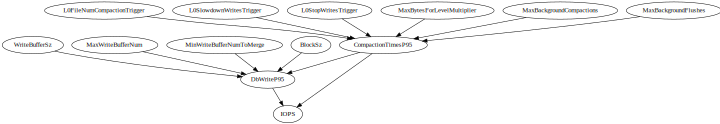

In [92]:
from autorocks.optimizer.bograph.bobn import BoBn

output_path = "/Users/salabed/workspace/latex_writings/thesis/phd_dissertation/Chapters/BoBn/Figures/rdb_struct"

G = rocksdb_10param_strctv2()
param_space = rocksdb_schema.RocksDB10Params()

bobn_graph = BoBn(G, param_space, {"iops"})

parents_iops = list(G.pred['iops'])

for (i, subgraph) in enumerate(bobn_graph._subgraphs):
    decomposed_subgraph = G.subgraph(subgraph._subgraph).copy()
    nodes = set(decomposed_subgraph.nodes())
    for p in parents_iops:
        if p not in nodes:
            decomposed_subgraph.add_node(p)
            decomposed_subgraph.add_edge(p, "iops")

    draw(decomposed_subgraph, f"{output_path}/subgraph_{i}.pdf")
    draw(decomposed_subgraph, f"{output_path}/subgraph_{i}.svg")

draw(G, f"{output_path}/rdb_dag.pdf")
draw(G, f"{output_path}/rdb_dag.svg")

draw(G)

# INITIAL DECOMPOSITIOn


In [141]:
G = rocksdb_10param_strctv1()
param_space = rocksdb_schema.RocksDB10Params()

bobn_graph = BoBn(G, param_space, {"iops"})

parents_iops = list(G.pred['iops'])

In [145]:
def generate_lows(pspace):
    """Generates default configuration for first iteration."""
    res = {}
    for param in pspace.parameters():
        res[param.name] = param.box.lower_bound
    return res

def generate_defaults(pspace):
    """Generates default configuration for first iteration."""
    res = {}
    for param in pspace.parameters():
        res[param.name] = param.box.default
    return res


defaults_df = pd.DataFrame([generate_defaults(param_space)])
defaults_df['method'] = "Default"


lower_df = pd.DataFrame([generate_lows(param_space)])
lower_df['method'] = "LowerBound"


def generate_upper(pspace):
    """Generates default configuration for first iteration."""
    res = {}
    for param in pspace.parameters():
        res[param.name] = param.box.upper_bound
    return res


upper_df = pd.DataFrame([generate_upper(param_space)])
upper_df['method'] = "UpperBound"


In [187]:
from autorocks.optimizer.bograph.bobn import ParametersDispenser
import botorch
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

no_struct = nx.DiGraph()
no_struct.add_edges_from([(p, "iops") for p in param_space.keys()])
bobn_no_struct = BoBn(no_struct, param_space, {"iops"})
p_dispencer = ParametersDispenser(param_space)

bounds = p_dispencer.bounds.numpy()

num_samples = 10

initial_random = [param_space.numpy_to_dict(p) for p in param_space.sample(num_samples, 1).T]
initial_samples_struct = bobn_graph.generate_initial_points(num_samples)
initial_samples_non_struct = bobn_no_struct.generate_initial_points(num_samples)

initial_struct_df = pd.DataFrame(initial_samples_struct)
initial_struct_df['method'] = "Structured+QMC"
initial_struct_df.reset_index(inplace = True)

initial_random_df = pd.DataFrame(initial_random)
initial_random_df['method'] = "Random"
initial_random_df.reset_index(inplace = True)

initial_no_stuct_df = pd.DataFrame(initial_samples_non_struct)
initial_no_stuct_df['method'] = "NoStruct+QMC"
initial_no_stuct_df.reset_index(inplace = True)

joint_initial_df = pd.concat([initial_struct_df, initial_random_df, initial_no_stuct_df])
joint_initial_df.rename(columns = {"index": "Step"}, inplace = True)

joint_initial_df.loc[:, list(param_space.keys())] = botorch.utils.transforms.normalize(joint_initial_df[list(param_space.keys())].values, bounds) 
joint_initial_df


,Step,write_buffer_size,max_bytes_for_level_multiplier,max_background_flushes,level0_slowdown_writes_trigger,level0_file_num_compaction_trigger,level0_stop_writes_trigger,max_background_compactions,min_write_buffer_number_to_merge,max_write_buffer_number,block_size,method
0,0,0.267725,0.266667,0.333333,0.707692,0.031746,0.539683,0.4,0.258065,0.362205,0.712345,Structured+QMC
1,1,0.801645,0.933333,0.777778,0.430769,0.936508,0.460317,1.0,0.870968,0.622047,0.175812,Structured+QMC
2,2,0.585902,0.666667,0.111111,0.923077,0.476190,0.031746,0.6,0.516129,0.141732,0.988943,Structured+QMC
3,3,0.110544,0.133333,0.555556,0.215385,0.571429,0.952381,0.0,0.161290,0.897638,0.400221,Structured+QMC
4,4,0.163408,0.200000,0.222222,0.369231,0.634921,0.857143,0.2,0.064516,0.102362,0.090420,Structured+QMC
5,5,0.626528,0.600000,0.666667,0.523077,0.285714,0.126984,0.8,0.709677,0.858268,0.548767,Structured+QMC
6,6,0.971209,0.733333,0.444444,0.030769,0.857143,0.365079,0.8,0.838710,0.377953,0.360636,Structured+QMC
7,7,0.441653,0.466667,0.888889,0.861538,0.206349,0.634921,0.2,0.451613,0.637795,0.777536,Structured+QMC
8,8,0.418718,0.400000,0.000000,0.092308,0.349206,0.380952,0.2,0.419355,0.196850,0.274699,Structured+QMC
9,9,0.884767,0.866667,0.555556,0.800000,0.682540,0.603175,0.6,0.806452,0.952756,0.863481,Structured+QMC


In [198]:
melted_df =joint_initial_df.melt(id_vars = ["Step", 'method'])
melted_df

,Step,method,variable,value
0,0,Structured+QMC,write_buffer_size,0.267725
1,1,Structured+QMC,write_buffer_size,0.801645
2,2,Structured+QMC,write_buffer_size,0.585902
3,3,Structured+QMC,write_buffer_size,0.110544
4,4,Structured+QMC,write_buffer_size,0.163408
...,...,...,...,...
295,5,NoStruct+QMC,block_size,0.694251
296,6,NoStruct+QMC,block_size,0.851562
297,7,NoStruct+QMC,block_size,0.183355
298,8,NoStruct+QMC,block_size,0.106192


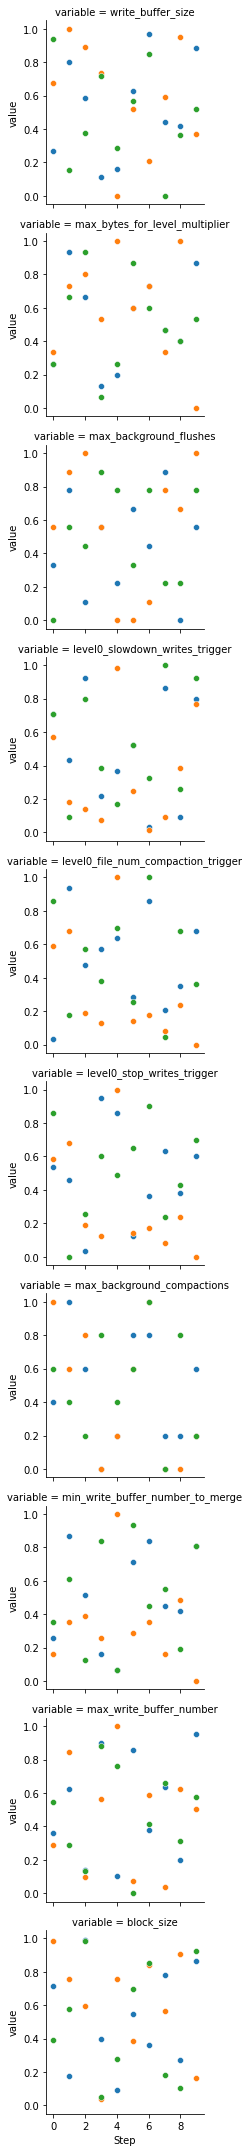

In [205]:
g = sns.FacetGrid(melted_df, row="variable", sharex = True, sharey = True, hue = 'method')
g.map(sns.scatterplot, "Step", "value")

[Text(0.5, 0, 'Method'), Text(0, 0.5, 'Write Buffer Size')]

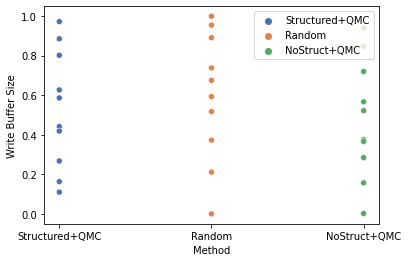

In [189]:

ax = sns.scatterplot(joint_initial_df, x = "method", y = "write_buffer_size", hue = 'method', palette = "deep")
# ax.axhline(y = defaults_df['write_buffer_size'].mean(), color = 'red', label = 'Default')
# ax.axhline(y = upper_df['write_buffer_size'].mean(), color = 'green', label = 'UpperBound')
# ax.axhline(y = lower_df['write_buffer_size'].mean(), color = 'green', label = 'LowerBound')
ax.legend()
ax.set(xlabel = "Method", ylabel = "Write Buffer Size")

In [149]:
sampling_output_path = "/Users/salabed/workspace/latex_writings/thesis/phd_dissertation/Chapters/BoBn/Figures/sampling"

for para in param_space.parameters():
    readable_name = para.name.replace("_", " ").title()
    print(readable_name)
    ax = sns.scatterplot(joint_initial_df, x = "method", y = para.name, hue = 'method', palette = "deep")
    ax.axhline(y = defaults_df[para.name].mean(), color = 'red', label = 'Default')
    ax.axhline(y = upper_df[para.name].mean(), color = 'green', label = 'UpperBound')
    ax.axhline(y = lower_df[para.name].mean(), color = 'green', label = 'LowerBound')

    ax.legend()
    ax.set(xlabel = "Method", ylabel = readable_name)
    plt.savefig(sampling_output_path + "/" + para.name + "_sampling.pdf", bbox_inches = 'tight')
    plt.savefig(sampling_output_path + "/" + para.name + "_sampling.svg", bbox_inches = 'tight')
    plt.close()


Max Background Compactions
Max Background Flushes
Write Buffer Size
Max Write Buffer Number
Min Write Buffer Number To Merge
Max Bytes For Level Multiplier
Block Size
Level0 File Num Compaction Trigger
Level0 Slowdown Writes Trigger
Level0 Stop Writes Trigger


,Step,write_buffer_size,max_bytes_for_level_multiplier,max_background_flushes,level0_slowdown_writes_trigger,level0_file_num_compaction_trigger,level0_stop_writes_trigger,max_background_compactions,min_write_buffer_number_to_merge,max_write_buffer_number,block_size,method
0,0,295146487,9,4,45,3,35,3,9,47,93663,Structured+QMC
1,1,862840160,19,8,27,60,30,6,28,80,23888,Structured+QMC
2,2,633449240,15,2,59,31,3,4,17,19,129634,Structured+QMC
3,3,128022704,7,6,13,37,61,1,6,115,53072,Structured+QMC
4,4,184230817,8,3,23,41,55,2,3,14,12783,Structured+QMC
5,5,676645705,14,7,33,19,9,5,23,110,72390,Structured+QMC
6,6,1043129295,16,5,1,55,24,5,27,49,47924,Structured+QMC
7,7,480075673,12,9,55,14,41,2,15,82,102141,Structured+QMC
8,8,455690152,11,1,5,23,25,2,14,26,36748,Structured+QMC
9,9,951220058,18,6,51,44,39,4,26,122,113318,Structured+QMC


In [207]:
bobn_graph.posterior(pd.DataFrame(bobn_graph.generate_initial_points(100)).values, False, bobn_graph.generate_initial_points(num_samples))

TypeError: list indices must be integers or slices, not str